In [6]:
from sklearn.model_selection import train_test_split
from lassonet import LassoNetClassifier
from lassonet.utils import eval_on_path
import torch
import pickle
from os.path import join
from pathlib import Path
from collections import defaultdict
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [6]:
device

'cuda'

In [2]:
seed = None
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 256
K = 50 # Number of features to select
n_epochs = 1000
dataset = 'ISOLET'

In [16]:
def load_data(fashion = False, digit = None, normalize = False):
    if fashion:
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    else:
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

    if digit is not None and 0 <= digit and digit <= 9:
        train = test = {y: [] for y in range(10)}
        for x, y in zip(x_train, y_train):
            train[y].append(x)
        for x, y in zip(x_test, y_test):
            test[y].append(x)

        for y in range(10):
            
            train[y] = np.asarray(train[y])
            test[y] = np.asarray(test[y])

        x_train = train[digit]
        x_test = test[digit]
    
    x_train = x_train.reshape((-1, x_train.shape[1] * x_train.shape[2])).astype(np.float32)
    x_test = x_test.reshape((-1, x_test.shape[1] * x_test.shape[2])).astype(np.float32)
    
    if normalize:
        X = np.concatenate((x_train, x_test))
        X = (X - X.min()) / (X.max() - X.min())
        x_train = X[: len(y_train)]
        x_test = X[len(y_train):]
    
#     print(x_train.shape, y_train.shape)
#     print(x_test.shape, y_test.shape)
    return (x_train, y_train), (x_test, y_test)


In [14]:
def load_fashion():
    train, test = load_data(fashion = True, normalize = True)
    x_train, x_test, y_train, y_test = train_test_split(test[0], test[1], test_size = 0.6)
    return (x_train, y_train), (x_test, y_test)

In [4]:
def load_mnist():
    train, test = load_data(fashion = False, normalize = True)
    x_train, x_test, y_train, y_test = train_test_split(test[0], test[1], test_size = 0.2)
    return (x_train, y_train), (x_test, y_test)


In [17]:
(X_train_valid, y_train_valid), (X_test, y_test) = load_fashion()
X_train, X_val, y_train, y_val = train_test_split(X_train_valid, y_train_valid, test_size=0.125, random_state=seed)

4422102/4422102 [==============================] - 0s 0us/step


In [18]:
data_dim = X_test.shape[1]
hidden_dim = (data_dim//3,) 

In [19]:
lasso_model = LassoNetClassifier(M=10, hidden_dims=hidden_dim, verbose=1, torch_seed=seed, random_state=seed, device=device, n_iters=n_epochs, batch_size=batch_size)


In [20]:
path = lasso_model.path(X_train, y_train, X_val=X_val, y_val=y_val)

C:\Users\Anton\anaconda3\lib\site-packages\lassonet\interfaces.py:464: UserWarning: lambda_start=3.277 (selected automatically) might be too large.
Features start to disappear at current_lambda=4.967.
  warnings.warn(


In [21]:
desired_save = next(save for save in path if save.selected.sum().item() <= K)
SELECTED_FEATURES = desired_save.selected
print("Number of selected features:", SELECTED_FEATURES.sum().item())

Number of selected features: 49


In [22]:
for save in path:
    print("Number of selected features:", save.selected.sum().item())

Number of selected features: 784
Number of selected features: 784
Number of selected features: 784
Number of selected features: 784
Number of selected features: 784
Number of selected features: 784
Number of selected features: 784
Number of selected features: 784
Number of selected features: 784
Number of selected features: 784
Number of selected features: 784
Number of selected features: 784
Number of selected features: 784
Number of selected features: 784
Number of selected features: 784
Number of selected features: 784
Number of selected features: 784
Number of selected features: 784
Number of selected features: 784
Number of selected features: 784
Number of selected features: 784
Number of selected features: 784
Number of selected features: 783
Number of selected features: 783
Number of selected features: 783
Number of selected features: 783
Number of selected features: 783
Number of selected features: 783
Number of selected features: 783
Number of selected features: 783
Number of 

In [18]:
# Select the features from the training, validation, and test data
X_train_selected = X_train[:, SELECTED_FEATURES]
X_val_selected = X_val[:, SELECTED_FEATURES]
X_test_selected = X_test[:, SELECTED_FEATURES]

In [19]:
# Initialize another LassoNetClassifier for retraining with the selected features
lasso_sparse = LassoNetClassifier(M=10, hidden_dims=hidden_dim, verbose=1, torch_seed=seed, random_state=seed, device=device, n_iters=n_epochs)
path_sparse = lasso_sparse.path(X_train_selected, y_train, X_val=X_val_selected, y_val=y_val, lambda_seq=[0], return_state_dicts=True)[:1]


In [20]:
# Evaluate the model on the test data
score = eval_on_path(lasso_sparse, path_sparse, X_test_selected, y_test)
print("Test accuracy:", score)


Test accuracy: [0.886]


In [22]:
X_train.shape

(7000, 784)

In [23]:
k_list = [194,174,152,125,99,75,49,40,31,20,11]
score_list=[]
for k in k_list:
    desired_save = next(save for save in path if save.selected.sum().item() == k)
    SELECTED_FEATURES = desired_save.selected
    X_train_selected = X_train[:, SELECTED_FEATURES]
    X_val_selected = X_val[:, SELECTED_FEATURES]
    X_test_selected = X_test[:, SELECTED_FEATURES]
    lasso_sparse = LassoNetClassifier(M=10, hidden_dims=hidden_dim, verbose=1, torch_seed=seed, random_state=seed, device=device, n_iters=n_epochs)
    path_sparse = lasso_sparse.path(X_train_selected, y_train, X_val=X_val_selected, y_val=y_val, lambda_seq=[0], return_state_dicts=True)[:1]
    score = eval_on_path(lasso_sparse, path_sparse, X_test_selected, y_test)
    score_list.append(score[0])
import pandas as pd

df = pd.DataFrame(data={'k' : k_list, 'lassonet' : score_list})


In [24]:
df

,k,lassonet
0,194,0.815833
1,174,0.814500
2,152,0.806000
3,125,0.802000
4,99,0.797167
5,75,0.786500
6,49,0.765667
7,40,0.761333
8,31,0.731000
9,20,0.682667


In [25]:
from sklearn.feature_selection import SelectKBest, f_classif
fisher_score = []
k_list = [200,175,150,125,100,75,50,40,30,20,10]
for k in k_list:
    selector = SelectKBest(score_func=f_classif, k=k)
    X_new = selector.fit_transform(X_train_valid, y_train_valid)
    SELECTED_FEATURES = selector.get_support(indices=True)
    X_train_selected = X_train[:, SELECTED_FEATURES]
    X_val_selected = X_val[:, SELECTED_FEATURES]
    X_test_selected = X_test[:, SELECTED_FEATURES]
    lasso_sparse = LassoNetClassifier(M=10, hidden_dims=hidden_dim, verbose=1, torch_seed=seed, random_state=seed, device=device, n_iters=n_epochs)
    path_sparse = lasso_sparse.path(X_train_selected, y_train, X_val=X_val_selected, y_val=y_val, lambda_seq=[0], return_state_dicts=True)[:1]
    score = eval_on_path(lasso_sparse, path_sparse, X_test_selected, y_test)
    fisher_score.append(score[0])


In [26]:
fisher_score

[0.7888333333333334,
 0.7903333333333333,
 0.7795,
 0.7568333333333334,
 0.7386666666666667,
 0.6823333333333333,
 0.6168333333333333,
 0.5915,
 0.5268333333333334,
 0.4811666666666667,
 0.4021666666666667]

In [27]:
score[0]

0.4021666666666667

In [28]:
df['fisher score'] = fisher_score

In [29]:
df

,k,lassonet,fisher score
0,194,0.815833,0.788833
1,174,0.814500,0.790333
2,152,0.806000,0.779500
3,125,0.802000,0.756833
4,99,0.797167,0.738667
5,75,0.786500,0.682333
6,49,0.765667,0.616833
7,40,0.761333,0.591500
8,31,0.731000,0.526833
9,20,0.682667,0.481167


In [30]:
!pip install pyHSICLasso
from pyHSICLasso import HSICLasso
k_list = [200,175,150,125,100,75,50,40,30,20,10]
hsic_lasso_list = []
for k in k_list:
    hsic_lasso = HSICLasso()
    hsic_lasso.input(X_train_valid,y_train_valid)
    hsic_lasso.classification(k)
    SELECTED_FEATURES = hsic_lasso.get_index()
    X_train_selected = X_train[:, SELECTED_FEATURES]
    X_val_selected = X_val[:, SELECTED_FEATURES]
    X_test_selected = X_test[:, SELECTED_FEATURES]
    lasso_sparse = LassoNetClassifier(M=10, hidden_dims=hidden_dim, verbose=1, torch_seed=seed, random_state=seed, device=device, n_iters=n_epochs)
    path_sparse = lasso_sparse.path(X_train_selected, y_train, X_val=X_val_selected, y_val=y_val, lambda_seq=[0], return_state_dicts=True)[:1]
    score = eval_on_path(lasso_sparse, path_sparse, X_test_selected, y_test)
    hsic_lasso_list.append(score[0])

Block HSIC Lasso B = 20.
M set to 3.
Using Gaussian kernel for the features, Delta kernel for the outcomes.


Block HSIC Lasso B = 20.
M set to 3.
Using Gaussian kernel for the features, Delta kernel for the outcomes.
Block HSIC Lasso B = 20.
M set to 3.
Using Gaussian kernel for the features, Delta kernel for the outcomes.
Block HSIC Lasso B = 20.
M set to 3.
Using Gaussian kernel for the features, Delta kernel for the outcomes.
Block HSIC Lasso B = 20.
M set to 3.
Using Gaussian kernel for the features, Delta kernel for the outcomes.
Block HSIC Lasso B = 20.
M set to 3.
Using Gaussian kernel for the features, Delta kernel for the outcomes.
Block HSIC Lasso B = 20.
M set to 3.
Using Gaussian kernel for the features, Delta kernel for the outcomes.
Block HSIC Lasso B = 20.
M set to 3.
Using Gaussian kernel for the features, Delta kernel for the outcomes.
Block HSIC Lasso B = 20.
M set to 3.
Using Gaussian kernel for the features, Delta kernel for the outcomes.
Block HSIC Lasso B = 20.
M set to 3.
Using Gaussian kernel for the features, Delta kernel for the outcomes.
Block HSIC Lasso B = 20.
M s

In [31]:
hsic_lasso_list

[0.8163333333333334,
 0.8193333333333334,
 0.8151666666666667,
 0.8176666666666667,
 0.8053333333333333,
 0.7913333333333333,
 0.7741666666666667,
 0.7548333333333334,
 0.7283333333333334,
 0.7028333333333333,
 0.5653333333333334]

In [32]:
df['hsic lasso'] = hsic_lasso_list

In [33]:
df

,k,lassonet,fisher score,hsic lasso
0,194,0.815833,0.788833,0.816333
1,174,0.814500,0.790333,0.819333
2,152,0.806000,0.779500,0.815167
3,125,0.802000,0.756833,0.817667
4,99,0.797167,0.738667,0.805333
5,75,0.786500,0.682333,0.791333
6,49,0.765667,0.616833,0.774167
7,40,0.761333,0.591500,0.754833
8,31,0.731000,0.526833,0.728333
9,20,0.682667,0.481167,0.702833


In [34]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from collections import defaultdict
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler

class PFA(object):
    def __init__(self, n_features, q=None):
        self.q = q
        self.n_features = n_features

    def fit(self, X):
        if not self.q:
            self.q = X.shape[1]

        pca = PCA(n_components=self.q).fit(X)
        A_q = pca.components_.T

        kmeans = KMeans(n_clusters=self.n_features).fit(A_q)
        clusters = kmeans.predict(A_q)
        cluster_centers = kmeans.cluster_centers_

        dists = defaultdict(list)
        for i, c in enumerate(clusters):
            dist = euclidean_distances([A_q[i, :]], [cluster_centers[c, :]])[0][0]
            dists[c].append((i, dist))

        self.indices_ = [sorted(f, key=lambda x: x[1])[0][0] for f in dists.values()]
        self.features_ = X[:, self.indices_]


In [35]:

# Testing

k_list = [200,175,150,125,100,75,50,40,30,20,10]
PFA_list = []
for k in k_list:
    pfa = PFA(n_features=k)
    pfa.fit(X_train_valid)
    SELECTED_FEATURES = pfa.indices_
    X_train_selected = X_train[:, SELECTED_FEATURES]
    X_val_selected = X_val[:, SELECTED_FEATURES]
    X_test_selected = X_test[:, SELECTED_FEATURES]
    lasso_sparse = LassoNetClassifier(M=10, hidden_dims=hidden_dim, verbose=1, torch_seed=seed, random_state=seed, device=device, n_iters=n_epochs)
    path_sparse = lasso_sparse.path(X_train_selected, y_train, X_val=X_val_selected, y_val=y_val, lambda_seq=[0], return_state_dicts=True)[:1]
    score = eval_on_path(lasso_sparse, path_sparse, X_test_selected, y_test)
    PFA_list.append(score[0])

In [36]:
PFA_list

[0.8138333333333333,
 0.8051666666666667,
 0.8068333333333333,
 0.8028333333333333,
 0.7933333333333333,
 0.7868333333333334,
 0.7436666666666667,
 0.7428333333333333,
 0.709,
 0.6726666666666666,
 0.4676666666666667]

In [37]:
df['PFA list'] = PFA_list

In [38]:
df

,k,lassonet,fisher score,hsic lasso,PFA list
0,194,0.815833,0.788833,0.816333,0.813833
1,174,0.814500,0.790333,0.819333,0.805167
2,152,0.806000,0.779500,0.815167,0.806833
3,125,0.802000,0.756833,0.817667,0.802833
4,99,0.797167,0.738667,0.805333,0.793333
5,75,0.786500,0.682333,0.791333,0.786833
6,49,0.765667,0.616833,0.774167,0.743667
7,40,0.761333,0.591500,0.754833,0.742833
8,31,0.731000,0.526833,0.728333,0.709000
9,20,0.682667,0.481167,0.702833,0.672667


In [39]:
X_train_selected = X_train
X_val_selected = X_val
X_test_selected = X_test
lasso_sparse = LassoNetClassifier(M=10, hidden_dims=hidden_dim, verbose=1, torch_seed=seed, random_state=seed, device=device, n_iters=n_epochs)
path_sparse = lasso_sparse.path(X_train_selected, y_train, X_val=X_val_selected, y_val=y_val, lambda_seq=[0], return_state_dicts=True)[:1]
all_features = eval_on_path(lasso_sparse, path_sparse, X_test_selected, y_test)


In [40]:
all_features*12

[0.8208333333333333,
 0.8208333333333333,
 0.8208333333333333,
 0.8208333333333333,
 0.8208333333333333,
 0.8208333333333333,
 0.8208333333333333,
 0.8208333333333333,
 0.8208333333333333,
 0.8208333333333333,
 0.8208333333333333,
 0.8208333333333333]

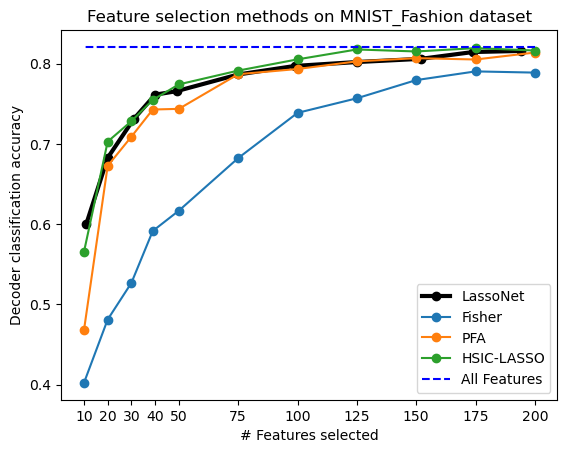

In [41]:
import matplotlib.pyplot as plt


df['k2'] = [200,175,150,125,100,75,50,39,30,20,10]

plt.plot(df['k'], df['lassonet'], label='LassoNet', marker='o',color='black',linewidth=3)
plt.plot(df['k2'], df['fisher score'], label='Fisher', marker='o')
plt.plot(df['k2'], df['PFA list'], label='PFA', marker='o')
plt.plot(df['k2'], df['hsic lasso'], label='HSIC-LASSO', marker='o')

plt.plot(df['k2'], all_features*11, label='All Features',color='blue', linestyle='--')



# Adding labels and title
plt.xlabel('# Features selected')
plt.ylabel('Decoder classification accuracy')
plt.title('Feature selection methods on MNIST_Fashion dataset')
plt.xticks(k_list)
# Adding legend to specify each line
plt.legend()

# Show plot
plt.show()


